# AION-Search Quick Start Tutorial

This notebook demonstrates how to use **AION-Search** to compute text-to-image similarity on astronomical images.

AION-Search is a CLIP-style model that projects AION embeddings (from galaxy images) and text embeddings (from OpenAI's `text-embedding-3-large`) into a shared semantic space, enabling natural language search over galaxy images.

## Steps
1. Download a galaxy image from the Legacy Survey
2. Generate AION embeddings for the image
3. Load the AION-Search projection model
4. Compute text-image similarities for natural language queries

## Step 1: Download a Galaxy Image

We'll fetch a galaxy cutout from the [DESI Legacy Imaging Survey](https://www.legacysurvey.org/). The image comes as a FITS file with 4 photometric bands (g, r, i, z).


Downloaded image shape: (4, 256, 256)  (bands, height, width)


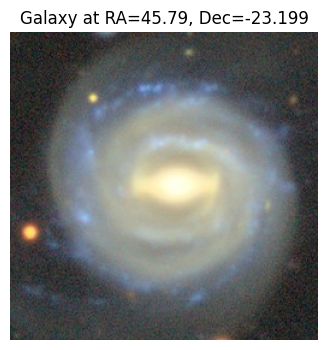

In [5]:
import matplotlib.pyplot as plt
from astropy.io import fits
from PIL import Image
import requests
from io import BytesIO

# Galaxy coordinates (RA, Dec) - try changing these to explore different galaxies!
ra, dec = 45.79, -23.199

# Build the Legacy Survey cutout URL
image_url = f"https://www.legacysurvey.org/viewer/cutout.fits?ra={ra}&dec={dec}&layer=ls-dr10&pixscale=0.262"

# Download the 4-band FITS image (g, r, i, z bands)
im = fits.getdata(image_url)
print(f"Downloaded image shape: {im.shape}  (bands, height, width)")

# Display a color preview using the Legacy Survey's JPG endpoint
jpg_url = image_url.replace("fits", "jpg")
response = requests.get(jpg_url)
img = Image.open(BytesIO(response.content))

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title(f"Galaxy at RA={ra}, Dec={dec}")
plt.axis("off")
plt.show()

## Step 2: Generate AION Embeddings

[AION](https://huggingface.co/polymathic-ai/aion-base) is a foundation model for astronomical images. We use it to extract a rich 768-dimensional embedding that captures the galaxy's morphological features.


In [6]:
import torch
import numpy as np
from aion.modalities import LegacySurveyImage
from aion.codecs import CodecManager
from aion.model import AION

# Automatically select the best available device (CUDA > MPS > CPU)
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")

# Disable gradient computation for inference
torch.set_grad_enabled(False)

# Convert the FITS image to a PyTorch tensor with batch dimension
image_flux = torch.tensor(im.astype("float32")).unsqueeze(0).to(device)

# Wrap in LegacySurveyImage with band metadata (required by AION)
image = LegacySurveyImage(flux=image_flux, bands=["DES-G", "DES-R", "DES-I", "DES-Z"])

# Initialize the codec manager (handles image preprocessing)
codec_manager = CodecManager(device=device)

# Load the pretrained AION model
model = AION.from_pretrained("polymathic-ai/aion-base").to(device).eval()

# Generate embeddings: encode the image and mean-pool over tokens
# Output shape: (1, 768) - one 768-dim embedding per image
image_embedding = model.encode(codec_manager.encode(image), num_encoder_tokens=600).mean(axis=1)
print(f"AION embedding shape: {image_embedding.shape}")

Using device: mps
AION embedding shape: torch.Size([1, 768])


## Step 3: Load the AION-Search Model

AION-Search consists of two projection heads that map AION image embeddings and OpenAI text embeddings into a shared 1024-dimensional space. We download the pretrained weights from HuggingFace.


In [7]:
from aionsearch import AIONSearchClipModel

# Load pretrained model from HuggingFace (downloads weights automatically)
clip_model = AIONSearchClipModel.from_pretrained(device=device)

# Project the AION embedding into the shared CLIP space
projected_image = clip_model.image_projector(image_embedding)
print(f"Projected image embedding shape: {projected_image.shape}")

Projected image embedding shape: torch.Size([1, 1024])


## Step 4: Text-to-Image Search

Now for the fun part! We can query the galaxy image using natural language. The process:
1. Get text embeddings from OpenAI's `text-embedding-3-large`
2. Project them into the shared space using `text_projector`
3. Compute cosine similarity between image and text embeddings

> **Note:** Cosine similarity ranges from -1 to +1. Positive scores indicate similarity, negative scores indicate dissimilarity.


In [8]:
from openai import OpenAI
from dotenv import load_dotenv

# Load OpenAI API key from .env file
load_dotenv()
client = OpenAI()

# Define natural language queries to test against the galaxy image
queries = [
    "A spiral galaxy with blue arms",
    "An edge-on disk galaxy", 
    "A small elliptical galaxy",
]

# Get text embeddings from OpenAI (3072-dimensional vectors)
response = client.embeddings.create(input=queries, model="text-embedding-3-large")
text_embeddings = torch.tensor([r.embedding for r in response.data], device=device)

# Project text embeddings into the shared CLIP space
projected_texts = clip_model.text_projector(text_embeddings)

# Compute cosine similarities (dot product of L2-normalized vectors)
similarities = (projected_image @ projected_texts.T).cpu().numpy().flatten()

# Display results
print(f"{'Query':<50} | {'Score':>8}")
print("-" * 62)
for query, score in zip(queries, similarities):
    print(f"{query:<50} | {score:>8.4f}")

# Find best match
best_idx = similarities.argmax()
print(f"\n✓ Best match: '{queries[best_idx]}' (score: {similarities[best_idx]:.4f})")


Query                                              |    Score
--------------------------------------------------------------
A spiral galaxy with blue arms                     |   0.3121
An edge-on disk galaxy                             |   0.0061
A small elliptical galaxy                          |  -0.1073

✓ Best match: 'A spiral galaxy with blue arms' (score: 0.3121)


## Next Steps

You've successfully found what description best matches this galaxy. Next you can explore using it for
1) text search over a dataset of embedded images
2) text+image search
3) zero-shot classification of images
4) Other ideas? Please email, we'd love to help!